[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202320_IMAGENES_Y_VISION/blob/main/Laboratorio%204/Practica/MISIS4825-M%26V2023%20-%20LAB4%20-%20Práctica.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

Práctica No. 4
==============

# Redes Convolucionales y Transfer Learning

Objetivos
---------

-   Aprender a implementar una red convolucional simple para tareas de clasificación de imágenes.
-   Aprender a implementar una red de transferencia utilizando modelos pre-entrenados.
-   Evaluar y comparar el rendimiento de un modelo de aprendizaje por transferencia frente a una red convolucional construida desde cero.

Contexto
--------

Las redes neuronales convolucionales son un tipo de red neuronal que se utiliza principalmente en tareas de visión artificial. Estas redes se caracterizan por tener una arquitectura que permite extraer características de las imágenes de forma eficiente. Por lo que son especialmente útiles en tareas de clasificación de imágenes, detección de objetos, segmentación semántica, entre otras. 

Entrenar una red convolucional desde cero puede ser costoso en términos de tiempo y recursos computacionales. Sobretodo si se cuenta con grandes conjuntos de datos e imágenes complejas. Por esta razón, es común utilizar redes pre-entrenadas. En esta práctica, se implementará una red convolucional simple para clasificar imágenes de lenguaje de señas. Luego, se implementará una red de transferencia utilizando un modelo pre-entrenado para la misma tarea.

Datos: [American Sign Language Dataset](https://www.kaggle.com/datasets/ayuraj/asl-dataset)

In [1]:
import json
import os
import shutil

# Numpy, Dataframes y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Keras y sus módulos
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import InceptionResNetV2


# Descarga y Preparación del Dataset de Kaggle

In [2]:
# Instalación de Kaggle
!pip install kaggle --quiet

In [3]:
# Credenciales desde kaggle.json
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Autenticar y descargar el dataset
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('ayuraj/asl-dataset', path='data', unzip=True)

# Eliminar la carpeta redundante si existe
redundant_folder_path = 'data/asl_dataset/asl_dataset'
if os.path.exists(redundant_folder_path):
    shutil.rmtree(redundant_folder_path)

# Exploración de datos

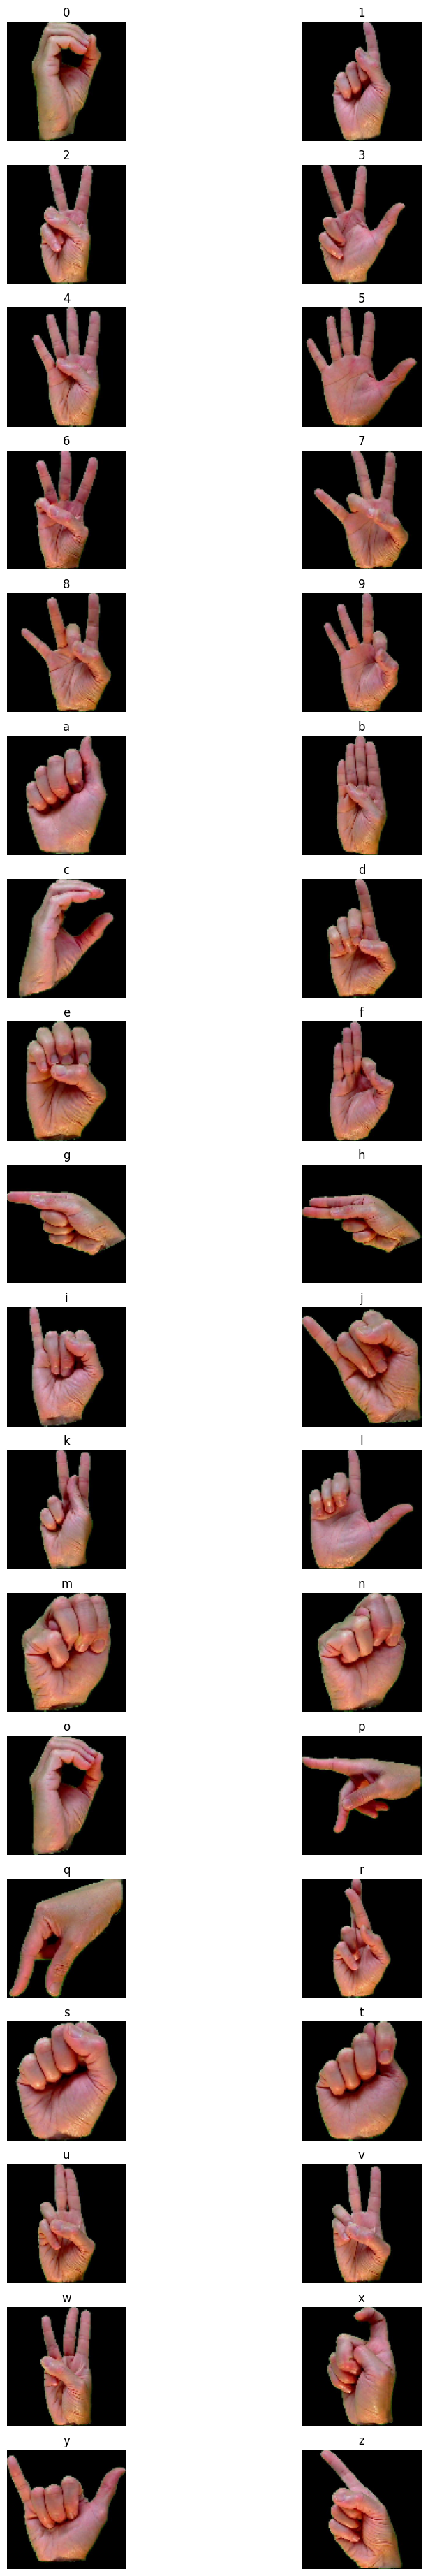

In [4]:


# Cargar y visualizar algunas imágenes del dataset
data_dir = 'data/asl_dataset'
asl_categories = os.listdir(data_dir)

# Visualizar una imagen de cada categoría
plt.figure(figsize=(10, 50))
for i, category in enumerate(asl_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100)) # Se carga la imagen como un objeto de tipo PIL (Python Imaging Library)
    plt.subplot(int(len(asl_categories)/2) + 1, 2, i+1)
    plt.title(category)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [5]:
# Análisis del tamaño y distribución de clases
image_count = {}
total_images = 0
for category in asl_categories:
    folder = os.path.join(data_dir, category)
    count = len(os.listdir(folder))
    image_count[category] = count
    total_images += count

print(f"Total de imágenes: {total_images}")
print("Número de imágenes por categoría:")
for category, count in image_count.items():
    print(f"{category}: {count}")

Total de imágenes: 2515
Número de imágenes por categoría:
0: 70
1: 70
2: 70
3: 70
4: 70
5: 70
6: 70
7: 70
8: 70
9: 70
a: 70
b: 70
c: 70
d: 70
e: 70
f: 70
g: 70
h: 70
i: 70
j: 70
k: 70
l: 70
m: 70
n: 70
o: 70
p: 70
q: 70
r: 70
s: 70
t: 65
u: 70
v: 70
w: 70
x: 70
y: 70
z: 70


# Preprocesamiento de Datos

In [6]:
# Guardar etiquetas y rutas de los archivos en un DataFrame
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']] # Directorio con todas las imágenes
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths] # Nombre de la carpeta de cada imagen
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Dividir los datos en entrenamiento, prueba y validación
train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=13)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=13) # 10% de prueba y 20% de validación

# Crear generadores de imágenes
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Leer imágenes de los directorios y generar batches de datos
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepath', y_col='label', target_size=(100, 100), batch_size=32)
test_gen = test_val_datagen.flow_from_dataframe(test_df, x_col='filepath', y_col='label', target_size=(100, 100), batch_size=32, shuffle=False)
val_gen = test_val_datagen.flow_from_dataframe(val_df, x_col='filepath', y_col='label', target_size=(100, 100), batch_size=32, shuffle=False)

Found 1760 validated image filenames belonging to 36 classes.
Found 251 validated image filenames belonging to 36 classes.
Found 504 validated image filenames belonging to 36 classes.


# Construcción del Modelo de Red Convolucional

- Conv2D: Aplica un conjunto de filtros aprendibles a una imagen. 

- MaxPooling2D: Esta capa reduce la dimensión espacial (altura y ancho) de los mapas de características de entrada. Esto ayuda a reducir el cómputo necesario para procesar los datos y también contribuye a hacer el modelo más generalizable al ignorar las variaciones menores en la imagen.

In [7]:
# Creación del modelo
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)), # Primera capa convolucional
    MaxPooling2D((2, 2)), # Capa de pooling
    Conv2D(32, (3, 3), activation='relu'), # Segunda capa convolucional
    AveragePooling2D((2, 2)), # Capa de pooling
    Flatten(), # Capa de aplanamiento
    Dense(16, activation='relu'), # Capa densa
    Dropout(0.2), # Capa de dropout
    Dense(len(asl_categories), activation='softmax') # Capa de salida
])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16928)             0         
                                                                 
 dense (Dense)               (None, 16)                2

# Compilación del Modelo

In [8]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks

In [9]:
# Model Checkpoint: Guarda el mejor modelo durante el entrenamiento.
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# EarlyStopping: Detiene el entrenamiento cuando una métrica monitoreada ha dejado de mejorar.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# ReduceLROnPlateau: Reduce la tasa de aprendizaje cuando una métrica ha dejado de mejorar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

# Lista de callbacks
callbacks = [model_checkpoint, early_stopping, reduce_lr]

# Entrenamiento del Modelo

In [10]:
# Entrenar el modelo
with tf.device('/device:GPU:0'): 
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

Epoch 1/50
55/55 [==============================] - 5s 45ms/step - loss: 2.9429 - accuracy: 0.1716 - val_loss: 1.9985 - val_accuracy: 0.4405 - lr: 0.0010
Epoch 2/50
55/55 [==============================] - 2s 42ms/step - loss: 2.0506 - accuracy: 0.3949 - val_loss: 1.2620 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 3/50
55/55 [==============================] - 2s 42ms/step - loss: 1.5518 - accuracy: 0.5358 - val_loss: 0.9895 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 4/50
55/55 [==============================] - 2s 42ms/step - loss: 1.2390 - accuracy: 0.6256 - val_loss: 0.7289 - val_accuracy: 0.8631 - lr: 0.0010
Epoch 5/50
55/55 [==============================] - 2s 42ms/step - loss: 1.0029 - accuracy: 0.6818 - val_loss: 0.5883 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 6/50
55/55 [==============================] - 2s 43ms/step - loss: 0.8901 - accuracy: 0.7290 - val_loss: 0.4975 - val_accuracy: 0.8790 - lr: 0.0010
Epoch 7/50
55/55 [==============================] - 2s 43ms/step - loss: 0.8

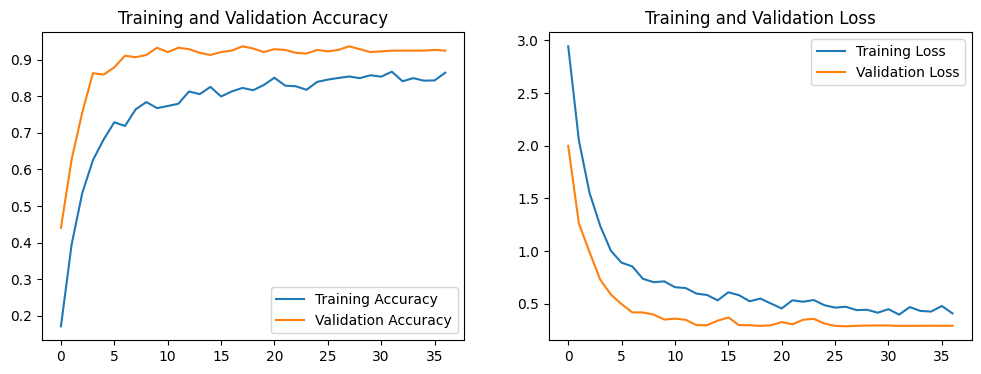

In [11]:
# Visualización de la progresión del entrenamiento

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [12]:
# Definir el generador en la misma configuración que el de entrenamiento
test_gen.reset()
# Obtener las etiquetas reales
y_test = test_gen.classes

# Realizar predicciones
predicciones = model.predict(test_gen, verbose=1)

# Convertir las predicciones en etiquetas
y_pred = np.argmax(predicciones, axis=1)

print(classification_report(y_test, y_pred, target_names=asl_categories))

8/8 [==============================] - 0s 54ms/step
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       1.00      0.88      0.93         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         4
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00         9
           6       0.86      0.75      0.80         8
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6
           a       1.00      0.86      0.92         7
           b       1.00      1.00      1.00         8
           c       1.00      1.00      1.00         6
           d       0.83      1.00      0.91        10
           e       0.75      1.00      0.86         9
           f       1.00      1.00      1.00         5
           g       1.00      

# Transfer Learning

In [13]:
# Número de clases
num_classes = len(asl_categories)

# Cargar la red InceptionV3 preentrenada sin la parte superior (top)
base_model = InceptionResNetV2(
    input_shape=(100, 100, 3),
    weights='imagenet', 
    include_top=False)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

transfer_learning_model = Sequential(
    [
        base_model,
        GlobalAveragePooling2D(),  # Global Average Pooling
        Dense(32, activation='relu'),  # Capa densa
        Dropout(0.2),  # Capa de dropout
        Dense(16, activation='relu'),  # Capa densa
        Dense(num_classes, activation='softmax') # Capa de salida
    ]
)

# Compilar el modelo
transfer_learning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostramos el resumen del modelo
transfer_learning_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 32)                49184     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 36)               

In [14]:
# Callback extra
model_checkpoint_transfer_learning = ModelCheckpoint('best_model_tl.h5', save_best_only=True, monitor='val_loss', mode='min')

callbacks_transfer_learning = [model_checkpoint_transfer_learning, early_stopping, reduce_lr]

In [15]:
# Entrenar el modelo
with tf.device('/device:GPU:0'): 
    history_transfer_learning = transfer_learning_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks_transfer_learning
    )

Epoch 1/50
55/55 [==============================] - 9s 85ms/step - loss: 3.5233 - accuracy: 0.0489 - val_loss: 3.1803 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 2/50
55/55 [==============================] - 3s 57ms/step - loss: 3.0148 - accuracy: 0.1653 - val_loss: 2.6036 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 3/50
55/55 [==============================] - 3s 57ms/step - loss: 2.5183 - accuracy: 0.2903 - val_loss: 1.9830 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 4/50
55/55 [==============================] - 3s 57ms/step - loss: 2.0201 - accuracy: 0.3960 - val_loss: 1.5785 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 5/50
55/55 [==============================] - 3s 61ms/step - loss: 1.7089 - accuracy: 0.4841 - val_loss: 1.3088 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 6/50
55/55 [==============================] - 3s 58ms/step - loss: 1.5117 - accuracy: 0.5318 - val_loss: 1.1555 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/50
55/55 [==============================] - 3s 57ms/step - loss: 1.3

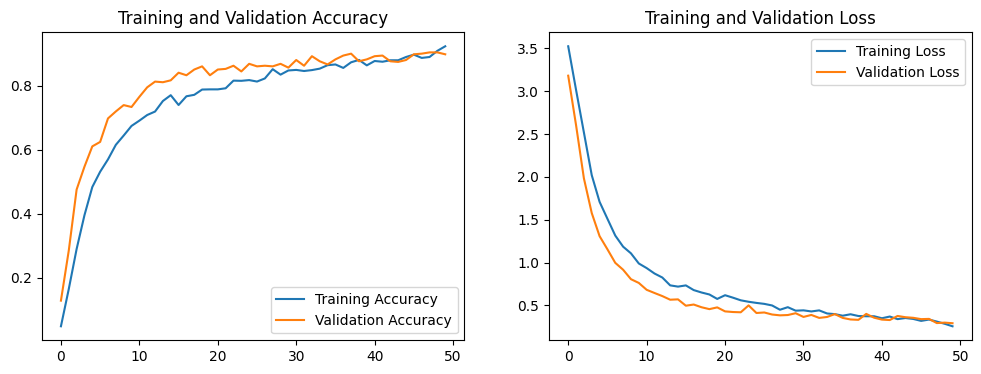

In [16]:
# Visualización de la progresión del entrenamiento

acc = history_transfer_learning.history['accuracy']
val_acc = history_transfer_learning.history['val_accuracy']
loss = history_transfer_learning.history['loss']
val_loss = history_transfer_learning.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [17]:
# Realizar predicciones
predicciones_tl = transfer_learning_model.predict(test_gen, verbose=1)

# Convertir las predicciones en etiquetas
y_pred_tl = np.argmax(predicciones_tl, axis=1)

print(classification_report(y_pred_tl, y_pred, target_names=asl_categories))

8/8 [==============================] - 2s 51ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.57      0.67      0.62         6
           2       0.89      0.80      0.84        10
           3       1.00      1.00      1.00         4
           4       0.80      0.67      0.73         6
           5       1.00      0.90      0.95        10
           6       0.71      0.71      0.71         7
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6
           a       1.00      0.75      0.86         8
           b       1.00      1.00      1.00         8
           c       1.00      1.00      1.00         6
           d       0.75      0.90      0.82        10
           e       0.75      1.00      0.86         9
           f       1.00      0.83      0.91         6
           g       1.00      

- ¿Si cambiamos la arqutectura de nuestra red convolucional simple por una más compleja, ¿mejoraría el rendimiento del modelo?
- ¿Es significativa la mejora de rendimiento/tiempo de entrenamiento de la red de transferencia frente a la red convolucional simple?
- ¿Si la imágen de entrada solo estuviera compues por un canal, ¿cómo cambiaría la arquitectura de la red convolucional? ¿Y la de transferencia?